In [1]:
from cmlreaders import CMLReader, get_data_index 
import matplotlib.pyplot as plt 
import scipy 
from scipy import stats 

import pandas as pd 
import numpy as np
import psutil 
import xarray
import os 

___________
## SPECIFY AND FILTER DATA 
_______

In [2]:
data = get_data_index('ltp')
VFFR = data[data['experiment']=='VFFR']

exp = 'VFFR'
session = np.unique(VFFR['session'])
subjects = VFFR['subject'].unique()

test_session = [1,2]
test_subs = ['LTP229','LTP246','LTP260']
my_data = ['LTP406']

Two subjects have been removed from overall subject pool because low performance or problems with reading EEG data 

General Filter:
 
Subjects were filtered out if they didn't complete 7 or more sessions 

In [3]:
print(session)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
#filter data 
subs = []
for sub in subjects:
    if sub != 'LTP419' and sub != 'LTP361':
        subs.append(sub)
        
subject_pool = []
skipped_subjects = []
skipped_log = []

for s in subs:
    print(s, end = ' ')
    s_count = 0 
    skip_count = 0 
    for sess in session:
        try:
            s_count += 1 
            reader = CMLReader(s, exp, session = session[sess])
            evs = reader.load('task_events')
            rec_evs = evs[(evs['type']=='REC_WORD_VV')|(evs['type']=='REC_WORD')]

        except:
            skipped_log.append('subject:'+str(s)+' session:'+str(sess))
            skip_count += 1 
            
    total = s_count - skip_count 
    if total >= 7:
        subject_pool.append(s)
    else:
        skipped_subjects.append(s)


LTP229 LTP246 LTP260 LTP312 LTP327 LTP329 LTP339 LTP347 LTP354 LTP355 LTP356 LTP365 LTP372 LTP386 LTP392 LTP400 LTP401 LTP402 LTP403 LTP404 LTP405 LTP406 LTP407 LTP408 LTP409 LTP410 LTP411 LTP412 LTP413 LTP414 LTP415 LTP416 LTP417 LTP418 LTP420 LTP421 LTP422 LTP423 LTP424 LTP425 LTP426 LTP427 LTP428 LTP429 LTP430 LTP431 LTP432 LTP433 LTP434 LTP435 LTP436 LTP437 LTP438 LTP439 LTP440 

In [5]:
print(skipped_log)

['subject:LTP260 session:7', 'subject:LTP312 session:6', 'subject:LTP312 session:9', 'subject:LTP327 session:2', 'subject:LTP329 session:2', 'subject:LTP329 session:5', 'subject:LTP354 session:3', 'subject:LTP354 session:4', 'subject:LTP354 session:5', 'subject:LTP354 session:6', 'subject:LTP354 session:7', 'subject:LTP354 session:8', 'subject:LTP354 session:9', 'subject:LTP386 session:5', 'subject:LTP386 session:6', 'subject:LTP386 session:7', 'subject:LTP386 session:8', 'subject:LTP386 session:9', 'subject:LTP392 session:1', 'subject:LTP392 session:7', 'subject:LTP392 session:8', 'subject:LTP392 session:9', 'subject:LTP403 session:5', 'subject:LTP403 session:6', 'subject:LTP403 session:7', 'subject:LTP403 session:8', 'subject:LTP403 session:9', 'subject:LTP409 session:0', 'subject:LTP409 session:6', 'subject:LTP409 session:7', 'subject:LTP409 session:8', 'subject:LTP409 session:9', 'subject:LTP410 session:2', 'subject:LTP410 session:3', 'subject:LTP410 session:4', 'subject:LTP410 ses

In [6]:
print(str(len(subject_pool))+' Subjects completed 7 or more sessions!')

39 Subjects completed 7 or more sessions!


___
## Functions 
____

In [53]:
def PullSession(subject = sub, exp = 'VFFR', session = 4):
    session_count = 0
    try:
        reader = CMLReader(subject,exp,session = session)
        evs = reader.load('task_events')

        word_evs = evs[evs['type']=='WORD']

        rec_evs = evs[evs['type']=='REC_WORD']

        rec_intrusion = rec_evs['intrusion']
        item_number = rec_evs['item_num']
        
        item_name = word_evs['item_name']
        serialposition = rec_evs['serialpos']
        Correct_rec_evs = rec_evs[rec_evs['intrusion']==False]
        session_count += 1
        
        return word_evs, rec_intrusion, item_number, item_name, serialposition, session_count 

    except: 
        pass 


def PullFFR(subject = sub, exp = 'VFFR', session = 5):
    session_count = 0
    try:
    

        reader = CMLReader(subject,exp,session = session)
        evs = reader.load('task_events')

        word_evs = evs[evs['type']=='WORD']

        rec_evs = evs[evs['type']=='FFR_REC_WORD']

        REC_ARRAY = rec_evs['item_name']
        session_count += 1 
        
        return rec_evs, session_count 
    
    except:
        pass 


    

In [9]:
ffr_session = [5,6,7,8,9]

In [10]:

skipped_log = []
subjects = subject_pool

master_my_recall = 0
for sub in subjects:
    my_recall = np.zeros(576)
    session_count = 0
    for f in ffr_session:
        #pull serial positions of previous sessions 
        try: 
            prior_rec_evs, prior_rec_intrusion, prior_item_num, prior_item_name, prior_sp, prior_session_count = PullSession(subject = sub, 
                                                                                                        exp = 'VFFR', 
                                                                                                        session = int(f-1))
            #convert to numpy array 
            presentation = prior_rec_evs['item_num'].to_numpy()

            #pull FFR words from session 
            FFR, count = PullFFR(subject = 'LTP406', 
                          exp = 'VFFR', 
                          session = f)
            session_count = session_count + count 

            #convert to numpy array 
            recall_event = FFR['item_num'].to_numpy()
        
            #if the recalled word is in prior array +1 to serial position 
            recalled_mask = np.isin(presentation,recall_event)
            my_recall[recalled_mask] += 1
            #probability across sessions completed by indivudal subjects 
        except:
            skipped_log.append('Subject: '+str(sub)+ ' Sessions: ' +str(f-1)+ ' and '+ str(f))
            pass 
        
    my_recall = my_recall/session_count 
    master_my_recall = master_my_recall + my_recall
#average across sessions 
master_my_recall = master_my_recall/len(subjects)
    
    
    

Text(0, 0.5, 'Probability of Recall')

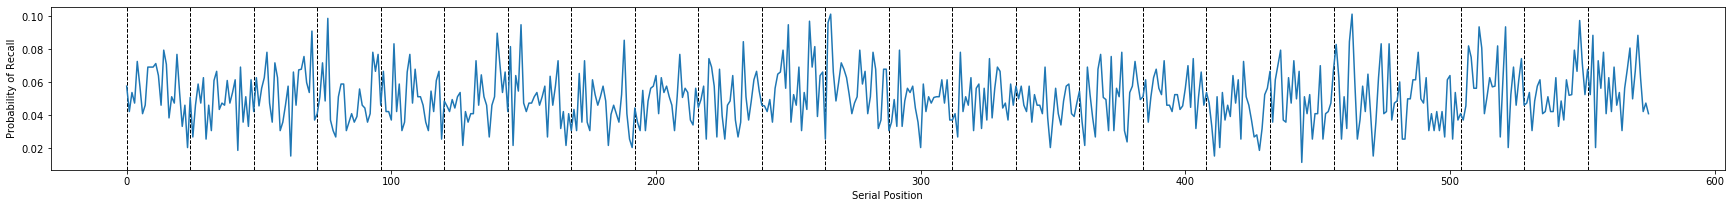

In [11]:
plt.figure(figsize = (30,3)); ax = plt.subplot(111)
x_line = np.arange(0,576,24)

#place virticle lines at the end/beginning of each block  
for x_ in x_line: 
    plt.axvline(x = int(x_), color = 'k', linestyle = '--', linewidth =1)
plt.plot(master_my_recall)
plt.xlabel('Serial Position')
plt.ylabel('Probability of Recall')

In [12]:
#split master list by blocks
split = np.split(master_my_recall,24)

/home1/brakat20/.conda/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


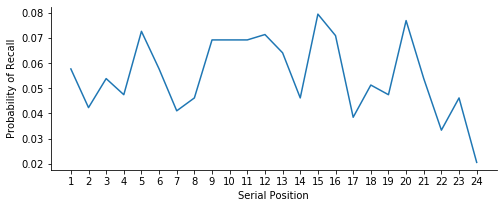

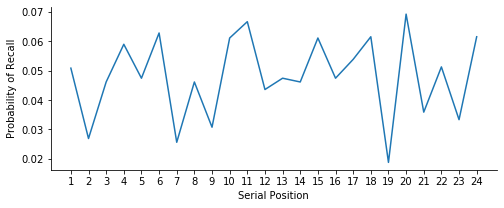

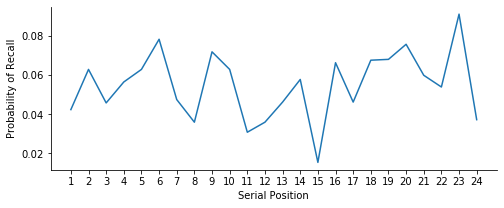

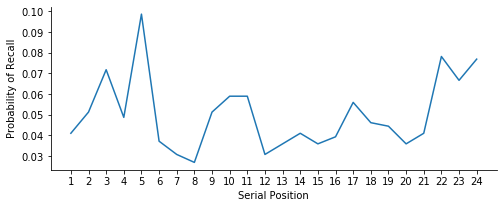

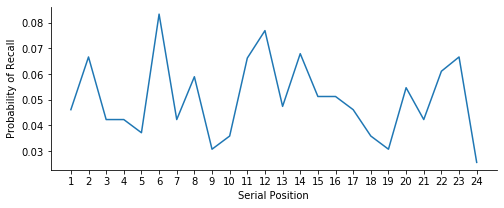

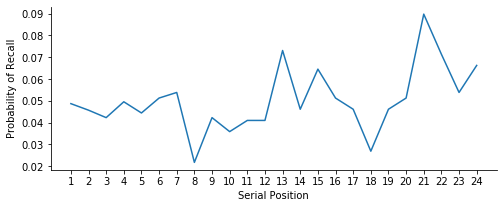

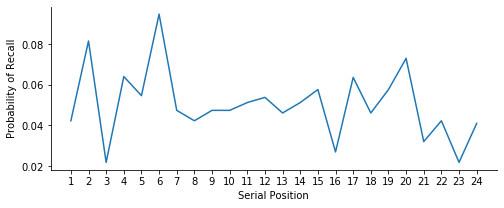

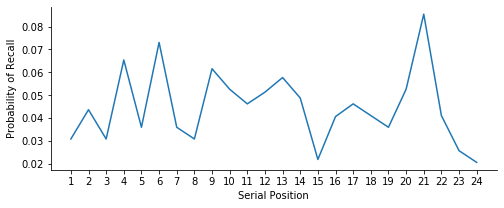

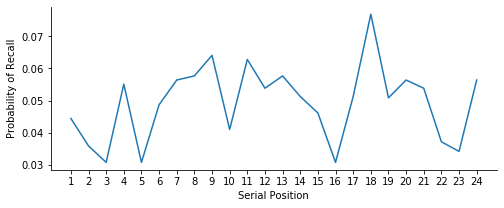

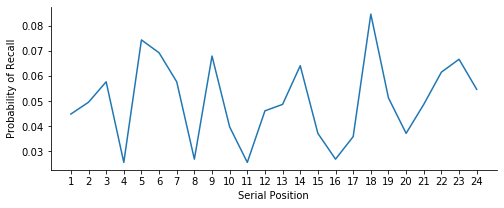

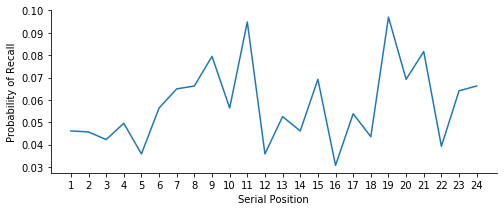

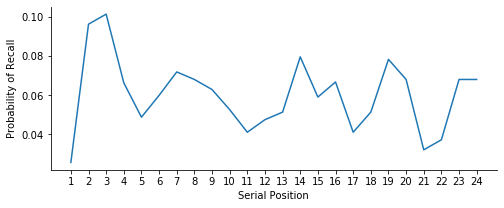

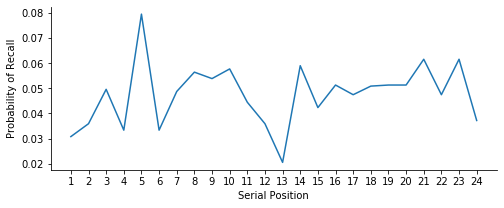

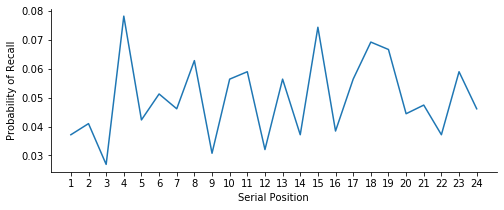

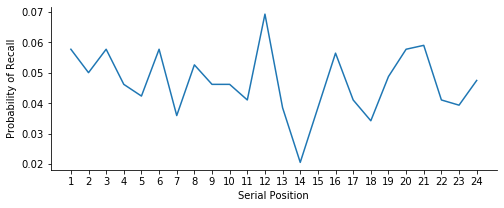

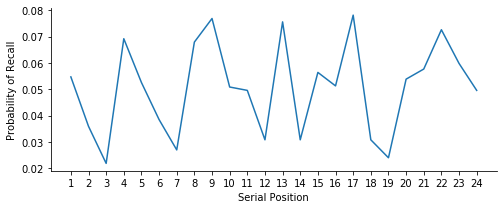

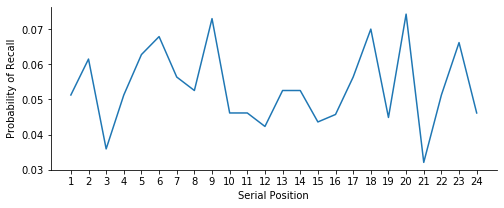

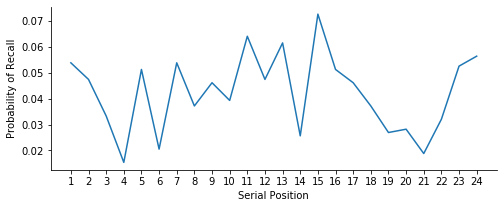

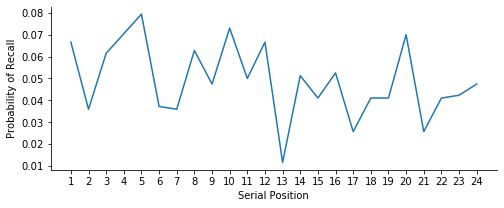

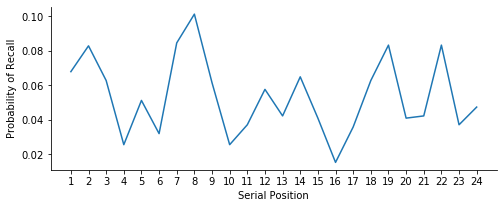

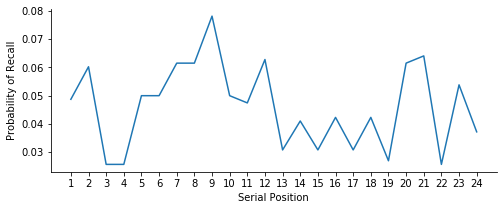

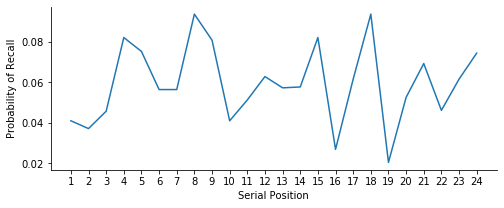

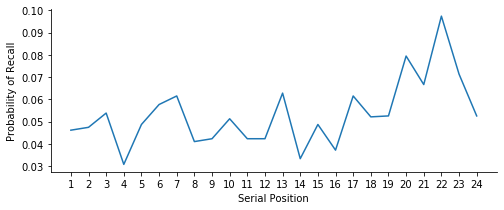

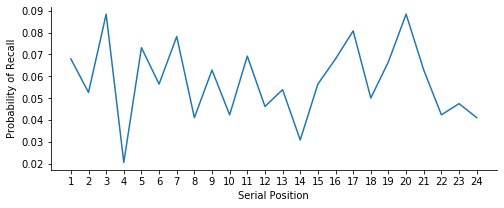

In [13]:
#plot each block individually
for x in split:
    plt.figure(figsize = (8,3)); ax = plt.subplot(111)
    ax.set_xticks(np.arange(0,24, step = 1))
    ax.set_xticklabels(np.arange(1,26, step = 1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Serial Position')
    plt.ylabel('Probability of Recall')
    plt.plot(x)

In [14]:
#average each block 
new_dict = {}
for shape in range(1,24):
    new_dict['{0}'.format(shape)] = 0
for x in split:
    for y,z in zip(np.arange(1,24),x):
        new_dict[str(y)] = new_dict[str(y)] + z

new_list = []
for w in new_dict:
    val = new_dict[str(w)]/24
    new_list.append(val)


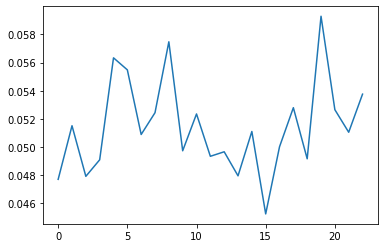

In [15]:
#average 
plt.plot(new_list)

# Track the number of times a specific item was recalled across session 5-9
___

In [16]:
my_data

['LTP406']

In [58]:

skipped_log = []
subjects = subject_pool

master_my_recall = 0
for sub in subjects:
    my_recall = np.zeros(576)
    session_count = 0
    #pull 576 item list from first session
    prior_rec_evs, prior_rec_intrusion, prior_item_num, prior_item_name, prior_sp, prior_session_count = PullSession(subject = sub, 
                                                                                                        exp = 'VFFR', 
                                                                                                        session = 1)
    #Convert to numpy array
    word_list = prior_rec_evs['item_num'].to_numpy()
    item_name_list = list(prior_item_name)
    
    word_pool_dict = {}

    for item_num,item_name in zip(word_list,item_name_list):
        word_pool_dict["{0}".format(item_num)] = item_name


    for f in ffr_session:
        
        try: 
    
            #pull FFR words from session 
            FFR, count = PullFFR(subject = 'LTP406', 
                          exp = 'VFFR', 
                          session = f)
            session_count = session_count + count 

            #convert to numpy array 
            recall_event = FFR['item_num'].to_numpy()
            recall_event = np.unique(recall_event)
            #if the recalled word is in prior array +1 to serial position 
            recalled_mask = np.isin(word_list,recall_event)
            my_recall[recalled_mask] += 1
            #probability across sessions completed by indivudal subjects 
        except:
            skipped_log.append('Subject: '+str(sub)+ ' Sessions: ' +str(f-1)+ ' and '+ str(f))
            pass 
    #average across useable session and add to master array    
    my_recall = my_recall/session_count 
    master_my_recall = master_my_recall + my_recall
#average across subjects
master_my_recall = master_my_recall/len(subjects)

#print words that have been recalled 4 out of 5 sessions or more 
high_prob = np.where(master_my_recall > .15)
for lst in high_prob:
    for prob in lst:
        position = word_list[prob]
        print(word_pool_dict[str(position)])
    
    
    

AIRPORT


Text(0, 0.5, 'Probability of Repeated Recall')

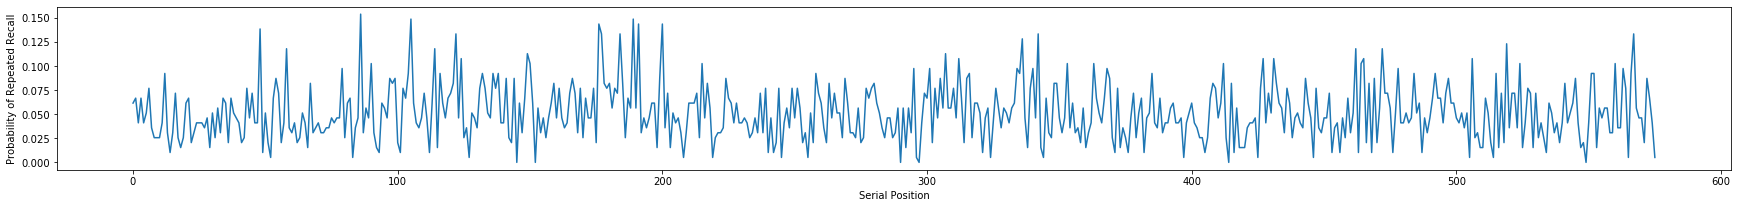

In [18]:
plt.figure(figsize = (30,3)); ax = plt.subplot(111)

plt.plot(master_my_recall)
plt.xlabel('Serial Position')
plt.ylabel('Probability of Repeated Recall')

array([0.06153846, 0.06666667, 0.04102564, 0.06666667, 0.04102564,
       0.05128205, 0.07692308, 0.03589744, 0.02564103, 0.02564103,
       0.02564103, 0.04102564, 0.09230769, 0.03076923, 0.01025641,
       0.03076923, 0.07179487, 0.02564103, 0.01538462, 0.02564103,
       0.06153846, 0.06666667, 0.02051282, 0.03076923, 0.04102564,
       0.04102564, 0.04102564, 0.03589744, 0.04615385, 0.01538462,
       0.05128205, 0.02564103, 0.05641026, 0.03076923, 0.06666667,
       0.06153846, 0.02051282, 0.06666667, 0.05128205, 0.04615385,
       0.04102564, 0.02051282, 0.02564103, 0.07692308, 0.04615385,
       0.07179487, 0.04102564, 0.04102564, 0.13846154, 0.01025641,
       0.05128205, 0.02051282, 0.00512821, 0.06666667, 0.08717949,
       0.07179487, 0.02051282, 0.04102564, 0.11794872, 0.03589744,
       0.03076923, 0.04102564, 0.02051282, 0.02564103, 0.05128205,
       0.04102564, 0.01538462, 0.08205128, 0.03076923, 0.03589744,
       0.04102564, 0.03076923, 0.03076923, 0.03589744, 0.03589

## Track Intrusions across sessions 

In [ ]:
# in the works 